In [2]:
# THANK YOU, VIVEK, FOR THIS BEAUTIFUL CODE. 
# Original code by Vivek. Modified by Brandon 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import sin, cos, sqrt, atan2

In [4]:
%matplotlib inline

In [5]:
df = pd.read_csv("../../api/bird_unofficial_api/csv_output.csv")

In [6]:
# Preprocessing and adding date columns
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
df['datetime'] = df['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
df['date_string'] = df['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['week_day'] = df['datetime'].apply(lambda x: days[x.weekday()])

In [7]:
df.head()

,id,latitude,longitude,battery_level,captive,time_stamp,datetime,date_string,week_day
0,efdcb512-0f67-4f87-91b0-22799c2bf265,34.413010,-119.855355,58,False,1550820003,2019-02-21 23:20:03,2019-02-21,thu
1,7c2a13b6-3665-4f48-a974-7da3027b1c10,34.413360,-119.856087,49,False,1550820003,2019-02-21 23:20:03,2019-02-21,thu
2,14552811-dc78-470d-8268-5427383ded9e,34.413730,-119.856170,37,False,1550820003,2019-02-21 23:20:03,2019-02-21,thu
3,b1e03b0f-a1e0-4801-9096-7dcbba49ed64,34.411740,-119.854775,56,False,1550820003,2019-02-21 23:20:03,2019-02-21,thu
4,f7fac8a3-b5d8-4421-ada2-c58990525a80,34.413167,-119.857628,69,False,1550820003,2019-02-21 23:20:03,2019-02-21,thu


In [8]:
df['date_string'].unique()

array(['2019-02-21', '2019-02-25', '2019-02-06', '2019-02-26',
       '2019-02-14', '2019-02-13', '2019-02-28', '2019-02-08',
       '2019-02-22', '2019-02-03', '2019-02-15', '2019-02-05',
       '2019-02-24', '2019-02-16', '2019-02-19', '2019-02-09',
       '2019-02-04', '2019-02-10', '2019-02-20', '2019-02-18',
       '2019-02-12', '2019-02-01', '2019-02-27', '2019-02-23',
       '2019-01-27', '2019-02-17', '2019-01-25', '2019-02-07',
       '2019-01-28', '2019-02-11', '2019-01-24', '2019-03-01'],
      dtype=object)

In [9]:
def get_count_for_date(ds):
    day_df = df[df['date_string'] == ds]
    freq_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['id'].nunique()
    freq_df.plot(figsize=(10,5))

In [10]:
# Group data by date
date_df = df.groupby('date_string')['id'].nunique()

In [11]:
# Group data by week day
week_day_df = df.groupby('week_day')['id'].nunique()
week_day_df = week_day_df.reindex(index = days) #To have the same order as we define in days

In [12]:
# Euclidean distance calculation (only roughly accurate for 10 min interval polling)
# start and end are tuples of (lat, long)
def distance(start, end):
    R = 6373.0
    dlon = end[1] - start[1]
    dlat = end[0] - start[0]
    a = (sin(dlat/2))**2 + cos(start[0]) * cos(end[0]) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance*1000 #km -> meters

In [13]:
# Return unique ids for given date
def day_ids(ds):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    unique_ids = pd.Series(day_df['id'].values).unique().tolist()
    print (pd.Series(day_df.id).nunique())
#     print (unique_ids)
    return unique_ids

In [14]:
# Returns df for specific Bird for a given day
def bird_data_by_day(ds, b_id):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    bird_df = day_df[day_df['id'] == b_id]
    return bird_df

In [15]:
def plot_bird_battery(ds, b_id):
    bird_df = bird_data_by_day(day, b_id)
    bird_df = bird_df.sort_values(by='datetime')
    bird_df = bird_df.reset_index(drop=True)
    bird_df.plot(x='datetime', y='battery_level', figsize=(10,5))

# Visualizations

156


/Users/brandonpon/Documents/git/birdwatcher/src/trend_analysis/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=737098.5069907408, right=737098.5069907408
  ax.set_xlim(left, right)


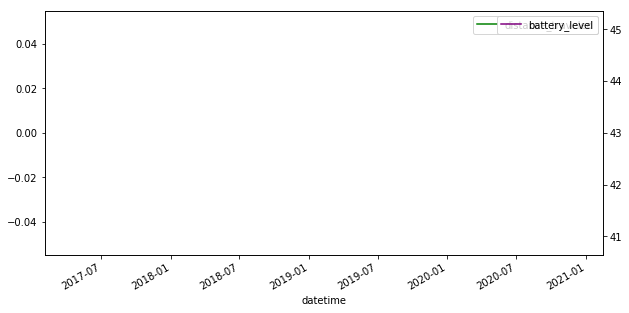

In [16]:
# overlapping plots of distance traveled and battery level
day = '2019-02-08'
unique_ids = day_ids(day)
bird_df = bird_data_by_day(day, unique_ids[1])
bird_df = bird_df.sort_values(by='datetime')
bird_df = bird_df.reset_index(drop=True)
bird_df['coordinates']= pd.Series(list(zip(bird_df.latitude, bird_df.longitude)))
dist_list = []
for i in range(len(bird_df.coordinates)):
    if i == 0:
        dist_list.append(0)
    else:
        dist_list.append(distance(bird_df.coordinates[i-1], bird_df.coordinates[i]))
bird_df['distance_traveled'] = pd.Series(dist_list)
# bird_df
ax = bird_df.plot(x='datetime', y=['distance_traveled'], figsize=(10,5), color = 'green')
ax1 = ax.twinx()

bird_df.plot(x='datetime', y='battery_level', ax = ax1, figsize=(10,5), color = 'purple')

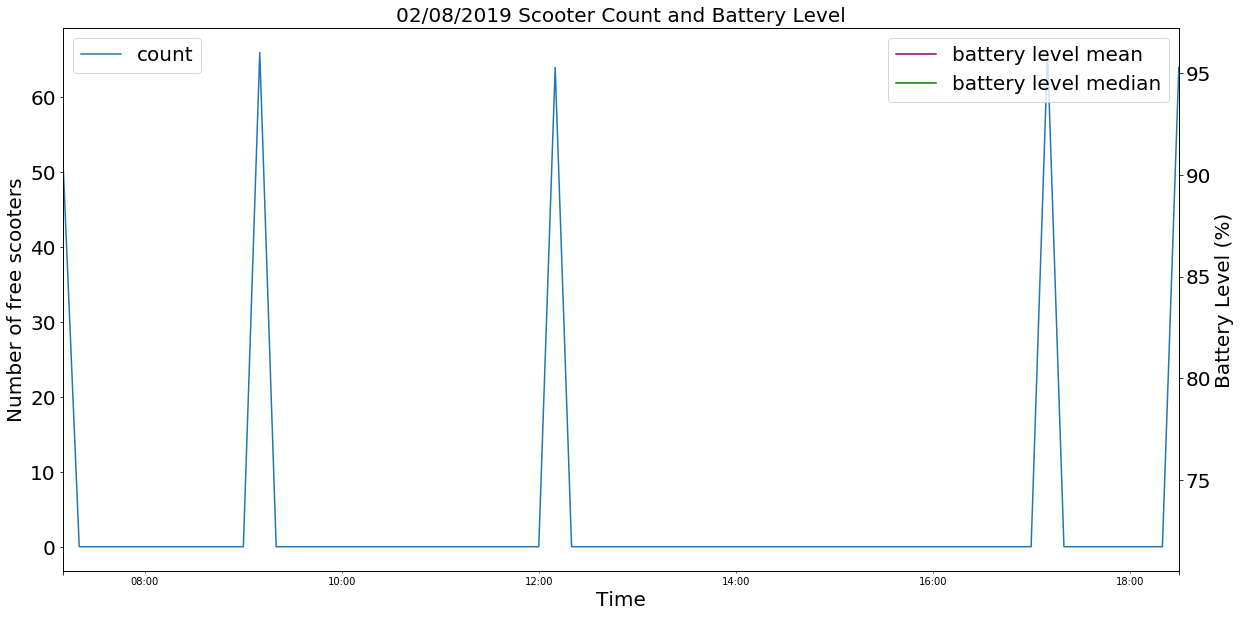

In [17]:
# Returns the large plot of battery and count for the powerpoint
day_df = df[df['date_string'] == '2019-02-08']
fontsize = '20'
freq_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['id'].nunique()
ax = freq_df.plot(figsize=(20,10), label = 'count')
ax1 = ax.twinx()
ax.set_title("02/08/2019 Scooter Count and Battery Level", fontsize = fontsize)
ax.set_xlabel("Time", fontsize = fontsize)
ax.legend(loc = 2, fontsize = fontsize)
ax.set_ylabel("Number of free scooters", fontsize = fontsize)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax1.set_ylabel("Battery Level (%)", fontsize = fontsize)
ax1.tick_params(axis = 'both', labelsize = fontsize)
bat_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['battery_level'].mean()
bat_df.plot(figsize=(20,10), ax=ax1, color= 'purple', label = 'battery level mean')
bat_df_median = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['battery_level'].median()
bat_df_median.plot(figsize = (20,10), ax=ax1, color= 'green', label = 'battery level median')
ax1.legend(fontsize = fontsize)

In [45]:
bat_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['battery_level'].apply(mode)
bat_df.plot(figsize=(20,10), ax=ax1, color= 'purple')

NameError: name 'mode' is not defined

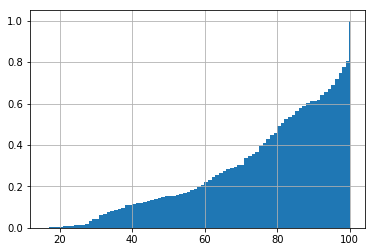

In [46]:
# CDF of a given day's battery level
day_df = df[df['date_string'] == '2019-02-08']
bat_df = day_df['battery_level']
bat_df.hist(cumulative=True, density=1, bins=1000)
plt.show()

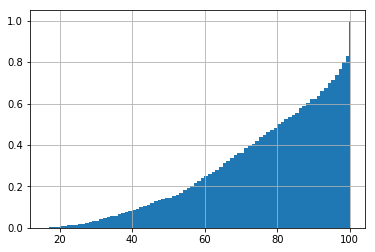

In [48]:
# CDF plot of all battery levels (in this repo)
df['battery_level'].hist(cumulative=True, density=1, bins = 1000)

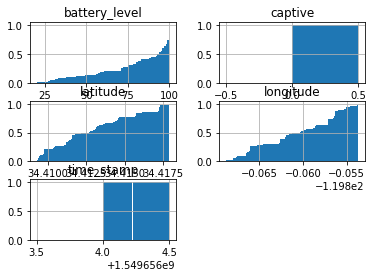

In [39]:
# all visualizations for given date and time. 
day_df = df[df['date_string'] == '2019-02-08']
one_plot = day_df[day_df['datetime'] == '2019-02-08 12:00:04']
one_plot.hist(cumulative=True, density=1, bins=1000)
plt.show()

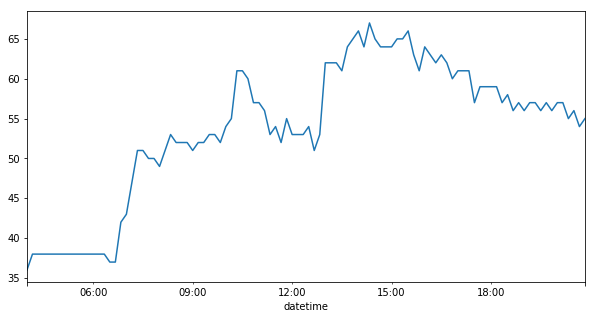

In [16]:
get_count_for_date('2019-02-04')

In [1]:
date_df.plot(kind='bar',figsize=(10,5))

NameError: name 'date_df' is not defined

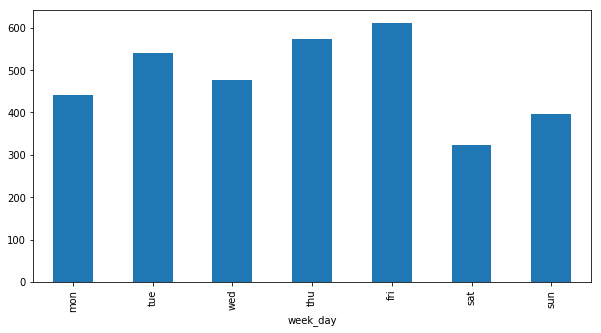

In [18]:
week_day_df.plot(kind='bar',figsize=(10,5))